In [1]:
!pip install shap

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import shap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
df = pd.read_csv('xai.csv', index_col=False)
df.columns = [i.zfill(2) for i in df.columns]
df.drop(axis=1, labels = 'Unnamed: 0', inplace=True)
df.head(5)

,00,01,02,03,04,05,06,07,08,09,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
X = df
y = df.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=42)

In [5]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           1       0.85      0.88      0.87       114
           2       0.71      0.67      0.69       208
           3       0.54      0.51      0.53       219
           4       0.79      0.25      0.38       105
           5       0.86      0.86      0.86       785
           6       0.57      0.44      0.50       197
           7       0.90      0.68      0.78        66
           8       0.63      0.85      0.72       767
           9       0.75      0.11      0.19        55
          10       0.67      0.38      0.49       180
          11       0.80      0.79      0.79       121
          12       0.78      0.87      0.82       602
          13       0.84      0.70      0.76       131
          14       0.69      0.40      0.51        92

    accuracy                           0.73      3642
   macro avg       0.74      0.60      0.63      3642
weighted avg       0.74      0.73      0.72      3642



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [6]:
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

In [7]:
print(len(shap_values))

14


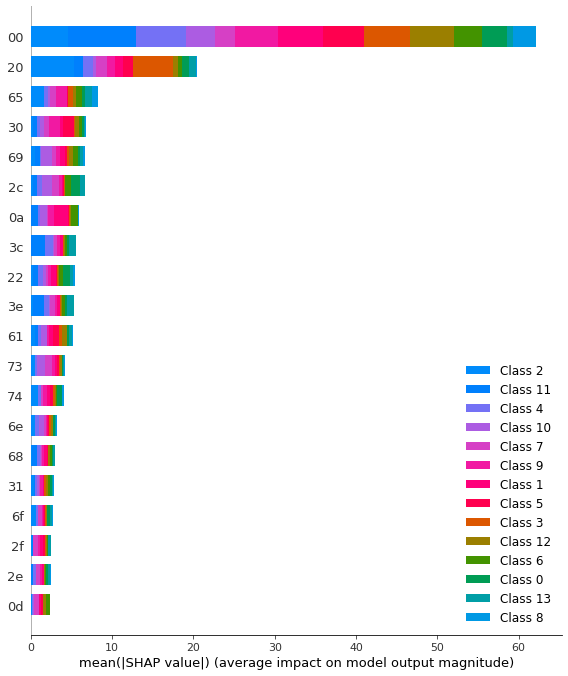

In [8]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

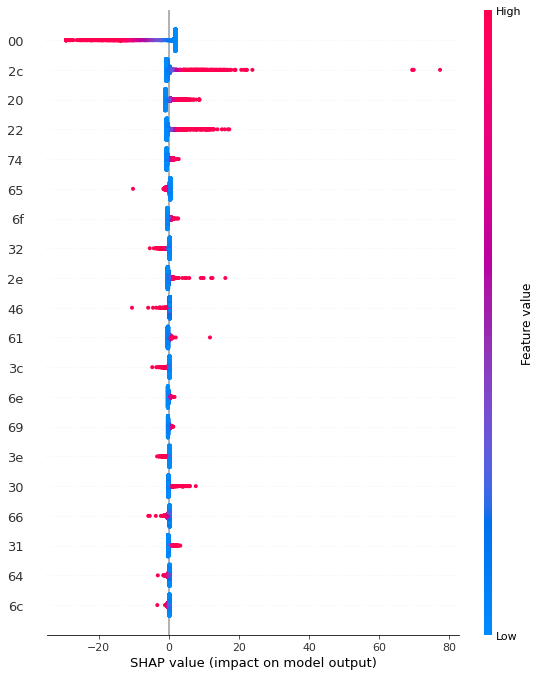

In [9]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test)

In [ ]:
#explanation = shap.Explanation(values=shap_values)
#get the plot for each class

for class_label in range(14):

    shap_values_class = shap_values[class_label]

    explanation = shap.Explanation(values=shap_values_class)

    shap.plots.beeswarm(explanation, max_display=12)

The below code helps to get the first 10 features with negatiev impact


In [11]:
class_index = 0  # Replace with the class index you want to analyze
shap_values_class = shap_values[class_index]

# Sort the absolute SHAP values in descending order
abs_shap_values = abs(shap_values_class)
sorted_indices = abs_shap_values.argsort()[::-1]

# Get the top 10 features with the most significant negative impact
top_10_negative_features = sorted_indices[:10]

# Print the feature indices or names
print("Top 10 features with negative impact for class", class_index)
print(top_10_negative_features)


Top 10 features with negative impact for class 0
[[113  10 106 ... 101 116   0]
 [ 84  96  74 ... 116  32   0]
 [ 77 121  89 ... 116  32   0]
 ...
 [222  74  89 ...  44  32   0]
 [ 66  37 113 ...  69   0  32]
 [ 10  37 113 ...  50   0  44]]


In [12]:
#store the aggregate scores for each feature
feature_scores = np.zeros(X_test.shape[1])

#Iterate through each class and accumulate the absolute SHAP values for each feature
for class_index in range(14):
    shap_values_class = shap_values[class_index].mean(0)  # Aggregate SHAP values across samples
    feature_scores += np.abs(shap_values_class)

# Sort the features by their aggregate scores in descending order
sorted_feature_indices = feature_scores.argsort()[::-1]

top_10_negative_features = sorted_feature_indices[:10]

print("Top 10 features with negative impact across all classes:")
print(top_10_negative_features)

feature_names = df.columns.tolist()

top_10_negative_feature_names = [feature_names[i] for i in top_10_negative_features]

print(top_10_negative_feature_names)



Top 10 features with negative impact across all classes:
[  0  32  48  70  44  34   7  13  49 101]
['00', '20', '30', '46', '2c', '22', '07', '0d', '31', '65']


In [13]:
new_X = X.drop(top_10_negative_feature_names, axis=1)
new_X.head()

,01,02,03,04,05,06,08,09,0a,0b,...,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff
0,0,0,0,0,0,0,0,0,18,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,11,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,12,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,15,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
             new_X, y, test_size = 0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           1       0.70      0.50      0.58       114
           2       0.52      0.60      0.55       208
           3       0.54      0.53      0.54       219
           4       0.40      0.16      0.23       105
           5       0.90      0.85      0.87       785
           6       0.52      0.47      0.49       197
           7       0.80      0.62      0.70        66
           8       0.65      0.82      0.72       767
           9       0.54      0.13      0.21        55
          10       0.55      0.39      0.45       180
          11       0.80      0.80      0.80       121
          12       0.73      0.87      0.80       602
          13       0.81      0.68      0.74       131
          14       0.76      0.32      0.45        92

    accuracy                           0.70      3642
   macro avg       0.66      0.55      0.58      3642
weighted avg       0.70      0.70      0.69      3642



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [15]:
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

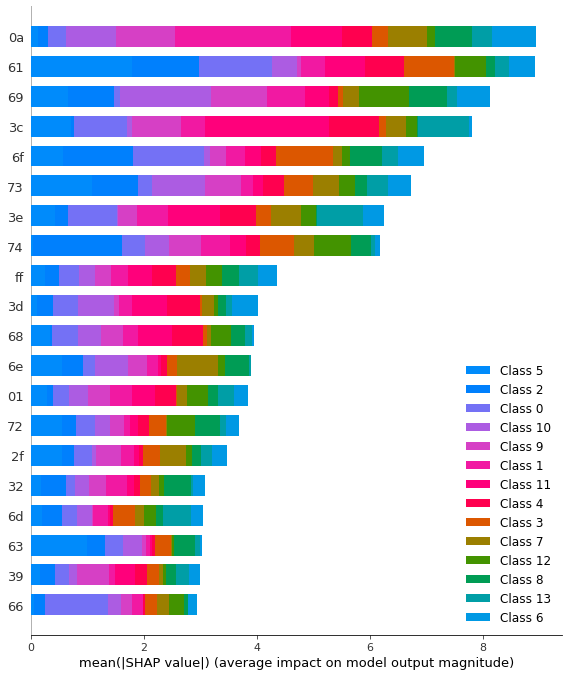

In [16]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

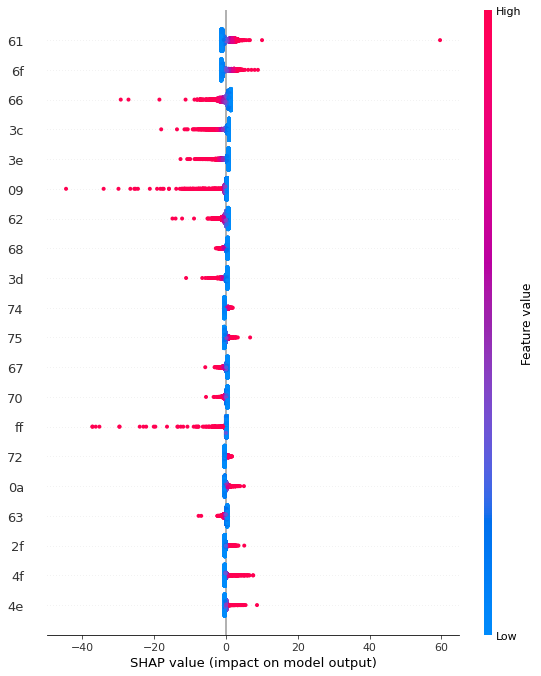

In [17]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test)

In [18]:
feature_scores = np.zeros(X_test.shape[1])

#Iterate through each class and accumulate the absolute SHAP values for each feature
for class_index in range(14):
    shap_values_class = shap_values[class_index].mean(0)  # Aggregate SHAP values across samples
    feature_scores += np.abs(shap_values_class)

# Sort the features by their aggregate scores in descending order
sorted_feature_indices = feature_scores.argsort()[::-1]

top_10_negative_features = sorted_feature_indices[:10]

print("Top 10 features with negative impact across all classes:")
print(top_10_negative_features)

feature_names = df.columns.tolist()

top_10_negative_feature_names = [feature_names[i] for i in top_10_negative_features]

print(top_10_negative_feature_names)

Top 10 features with negative impact across all classes:
[  1 245  64   0 102   7  52  91  92  54]
['01', 'f5', '40', '00', '66', '07', '34', '5b', '5c', '36']
